<a href="https://colab.research.google.com/github/chloe-dg/credit_card_fraud_detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1: Import packages, load dataset, EDA and Data Preprocessing

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
credit = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/database/creditcard.csv')

In [ ]:
data = credit.copy()

## Exploratory Data Analysis & Data Preprocessing

## 1. Explore the columns and classes

In [ ]:
# Explore columns in the dataset
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Text(0, 0.5, 'Frequency')

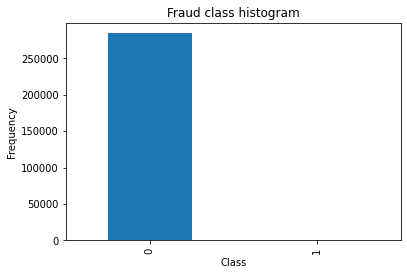

In [ ]:
# Compare different classes in the dataset
classes = data['Class'].value_counts()
classes.plot( kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [ ]:
# Fraud rate is only 0.17%, dataset is very skewed towards non-fraud
non_fraud = classes[0]/(classes[0]+classes[1])
fraud = classes[1]/(classes[0]+classes[1])
print(f'Non-fraud rate is {non_fraud: .2%}')
print(f'Fraud rate is {fraud: .2%}')


Non-fraud rate is  99.83%
Fraud rate is  0.17%


## 2. Explore features correlation

Text(0.5, 1.0, 'Imbalanced Correlation Matrix')

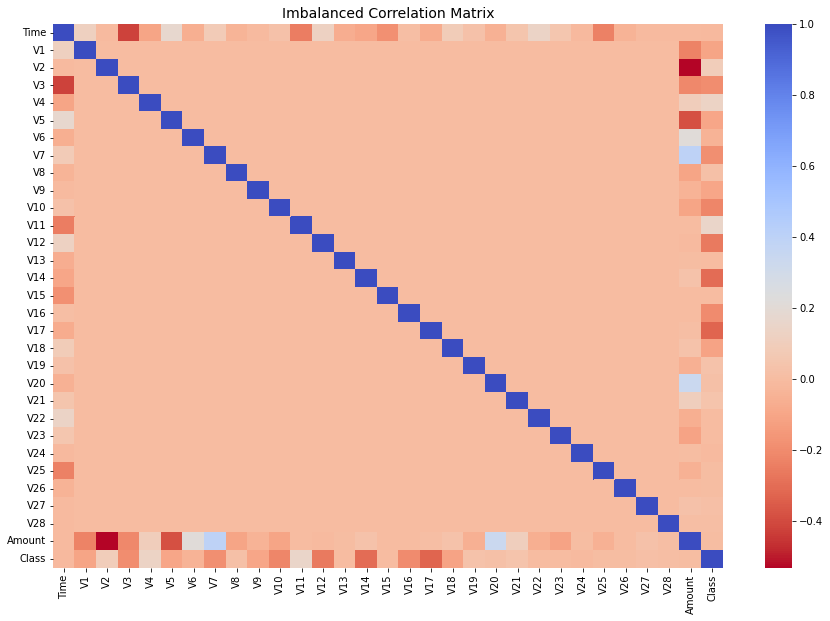

In [ ]:
# Make sure we use the subsample in our correlation
f, ax1 = plt.subplots(figsize=(15,10))

# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


## 3. Using Standard scaler and Robust scaler on "Amount" and "Time" columns

In [ ]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['amount_scaled'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['time_scaled'] = std_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [ ]:
data.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-1.996541


## 4. Create train and test dataset

In [ ]:
X = data.drop('Class', axis=1)
y = data['Class']

# Apply kfold
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))
print(f'len of original dataset: {len(original_Xtrain)+len(original_Xtest): ,.0f}')
print(f'len of train set: {len(original_Xtrain): ,.0f}')
print(f'len of test set: {len(original_Xtest): ,.0f}')


----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]
len of original dataset:  284,807
len of train set:  227,846
len of test set:  56,961


#### Structure of the next part: Create undersampling and oversampling datasets to let model learn from a more balanced datasets. We then will compare which dataset will have better performance in term of recall score. 

# Part 2: Undersampling dataset

In [ ]:
# Sample from original dataset to create undersample dataset
data = data.sample(frac=1)

fraud_data = data.loc[data['Class'] == 1]
nonfraud_data = data.loc[data['Class'] == 0][:492]

undersample_data = pd.concat([fraud_data, nonfraud_data])

undersample_data = undersample_data.sample(frac=1, random_state=42)
undersample_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
200131,1.871262,-0.385948,-0.456959,1.395105,-0.310323,0.391588,-0.539901,0.350113,1.227153,0.202701,0.081677,0.266919,-2.430002,0.351332,-1.590681,-0.167043,-0.134091,-0.185604,0.443118,-0.378852,-0.490017,-1.305198,0.489287,0.560154,-0.424912,-1.149198,0.033388,-0.036587,0,-0.070006,0.810396
229730,1.894036,1.905806,-3.515730,4.508913,2.044466,-1.420468,1.057480,-0.281157,-1.832604,-0.628463,2.220795,-0.741088,-0.763719,-4.942612,-1.378291,2.244216,3.702065,2.256812,-1.950060,-0.160163,-0.144713,-0.310108,-0.101530,-0.414960,0.376597,0.150778,-0.013712,0.048084,1,-0.276392,1.078421
239122,-1.023006,0.655312,1.244153,-0.335054,-0.426831,-0.581691,-0.091921,0.548732,0.306748,-0.815144,-1.466105,-0.287306,-0.665280,0.132590,-0.003398,0.343426,-0.310608,0.340475,-0.378624,-0.029995,0.279231,0.808022,-0.225303,0.081515,-0.042907,0.456163,0.227467,0.100087,0,-0.050304,1.161326
223572,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,-5.653638,3.942316,-5.883724,-1.347814,-9.266120,-2.459556,-2.205644,-5.709087,-1.113937,-1.556530,0.164288,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1,-0.293440,1.023839
40085,1.083693,1.179501,-1.346150,1.998824,0.818034,-0.771419,0.230307,0.093683,-0.167594,-1.959809,2.804335,0.312424,-0.595976,-4.662577,-0.299515,1.001414,3.902825,1.619609,-0.888087,-0.060159,-0.312000,-0.639700,-0.120249,-0.180218,0.609283,-0.339524,0.096701,0.114972,1,-0.293440,-1.152455


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


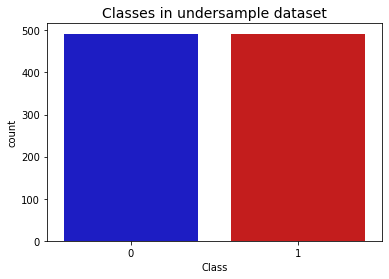

In [ ]:
# Testing the undersample dataset
print('Distribution of the Classes in the subsample dataset')
print(undersample_data['Class'].value_counts()/len(undersample_data))

colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=undersample_data, palette=colors)
plt.title('Classes in undersample dataset', fontsize=14)
plt.show()

Observation: Pay attention to features that have high correlation to Class: 
- Positive correlation: V11, V4, V2, V19
- Negative correlation: V17, V14, V12, V10

Text(0.5, 1.0, 'Undersample Correlation Matrix')

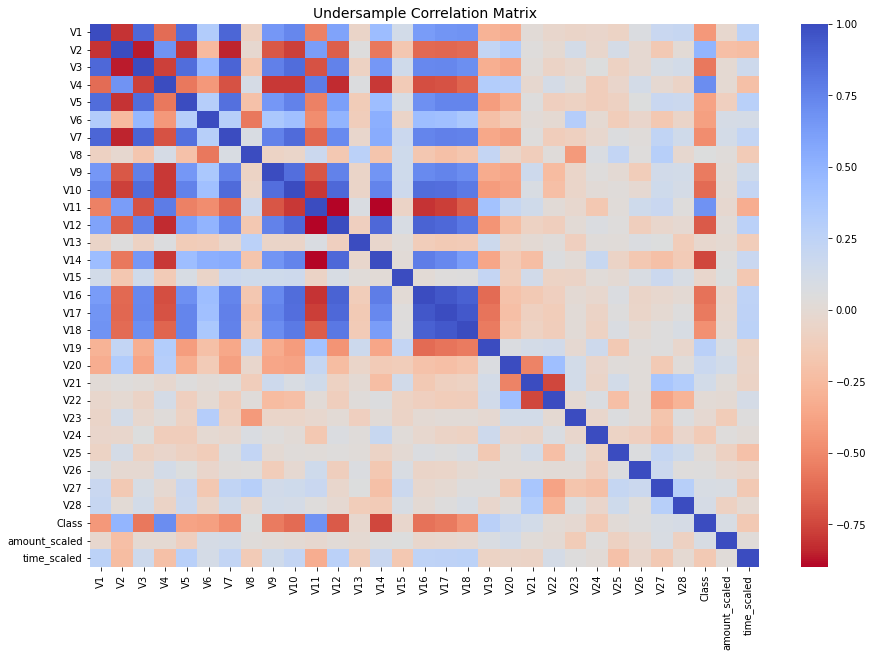

In [ ]:
# Create correlation matrix in undersample dataset
f, ax1 = plt.subplots(figsize=(15,10))

# Entire DataFrame
corr = undersample_data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Undersample Correlation Matrix", fontsize=14)


## Train undersample dataset

In [ ]:
# X_undersample = X_reduced_pca
X_undersample = undersample_data.drop('Class', axis=1)
y_undersample = undersample_data['Class']

In [ ]:
# undersample dataset
X_undersample_train, X_undersample_test, y_undersample_train, y_undersample_test = train_test_split(X_undersample,y_undersample,test_size=0.3,random_state=2022)

print("Number transactions train dataset: ", len(X_undersample_train))
print("Number transactions test dataset: ", len(X_undersample_test))
print("Total number of transactions: ", len(X_undersample_train)+len(X_undersample_test))

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [ ]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [ ]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_undersample_train, y_undersample_train)
    training_score = cross_val_score(classifier, X_undersample_train, y_undersample_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score") 

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


In [ ]:
# Finding the best parameter for each model

# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_undersample_train, y_undersample_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_undersample_train, y_undersample_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_undersample_train, y_undersample_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_undersample_train, y_undersample_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_



In [ ]:
print(f"Log Reg best estimator is: {log_reg}")
print(f"K Neighbor best estimator is: {knears_neighbors}")
print(f"Support Vector Machine best estimator is: {svc}")
print(f"Decision Tree best estimator is: {tree_clf}")

Log Reg best estimator is: LogisticRegression(C=0.1)
K Neighbor best estimator is: KNeighborsClassifier(n_neighbors=4)
Support Vector Machine best estimator is: SVC(C=0.5, kernel='linear')
Decision Tree best estimator is: DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)


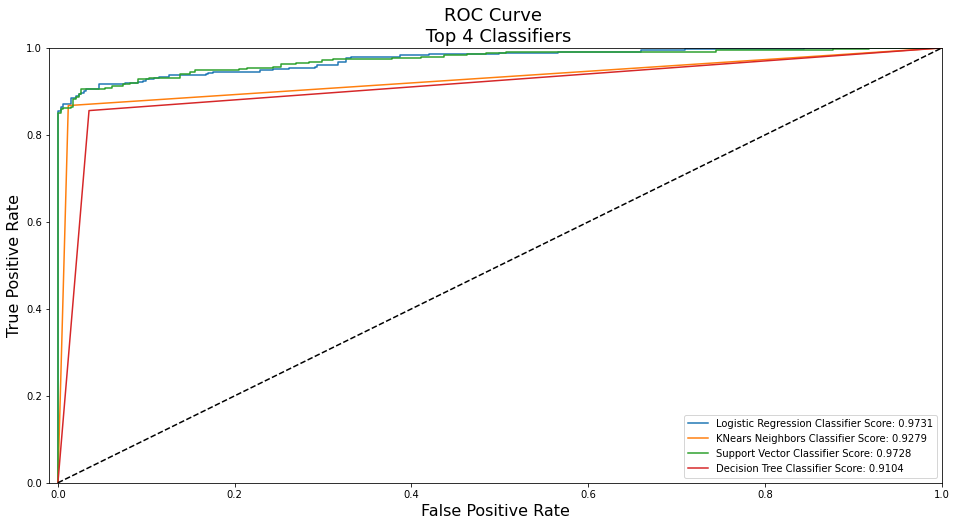

In [ ]:
# Create ROC Curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_undersample_train, y_undersample_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_undersample_train, y_undersample_train, cv=5)

svc_pred = cross_val_predict(svc, X_undersample_train, y_undersample_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_undersample_train, y_undersample_train, cv=5)

# Create ROC curve
log_fpr, log_tpr, log_thresold = roc_curve(y_undersample_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_undersample_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_undersample_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_undersample_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_undersample_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_undersample_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_undersample_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_undersample_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

### Final result on undersample dataset for each model

In [ ]:
# Logistic Regression
print('Logistic Regression: \n')

y_pred = log_reg.predict(X_undersample_test)
print('Recall Score: {:.2f}'.format(recall_score(y_undersample_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_undersample_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_undersample_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_undersample_test, y_pred)))
print('---' * 25)

print('K-nearest neighbors: \n')

y_pred = knears_neighbors.predict(X_undersample_test)
print('Recall Score: {:.2f}'.format(recall_score(y_undersample_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_undersample_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_undersample_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_undersample_test, y_pred)))
print('---' * 25)

print('Support Vector Machine: \n')

y_pred = svc.predict(X_undersample_test)
print('Recall Score: {:.2f}'.format(recall_score(y_undersample_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_undersample_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_undersample_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_undersample_test, y_pred)))
print('---' * 25)

print('Decision Tree: \n')

y_pred = tree_clf.predict(X_undersample_test)
print('Recall Score: {:.2f}'.format(recall_score(y_undersample_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_undersample_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_undersample_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_undersample_test, y_pred)))
print('---' * 25)


Logistic Regression: 

Recall Score: 0.92
Precision Score: 0.97
F1 Score: 0.95
Accuracy Score: 0.95
---------------------------------------------------------------------------
K-nearest neighbors: 

Recall Score: 0.88
Precision Score: 0.98
F1 Score: 0.93
Accuracy Score: 0.93
---------------------------------------------------------------------------
Support Vector Machine: 

Recall Score: 0.94
Precision Score: 0.96
F1 Score: 0.95
Accuracy Score: 0.95
---------------------------------------------------------------------------
Decision Tree: 

Recall Score: 0.88
Precision Score: 0.98
F1 Score: 0.93
Accuracy Score: 0.93
---------------------------------------------------------------------------


#### Logistic Regression has the highest Recall and Precision score. We will compare the score of logistic regression in undersamle dataset to the score of best model in oversample dataset

# Part 3. Oversampling dataset

In [ ]:
# Original dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961


## 3.1 Random forest

In [ ]:
# Apply borderline SMOTE to oversampling dataset
from imblearn.over_sampling import BorderlineSMOTE
borderlineSMOTE = BorderlineSMOTE(k_neighbors = 10, random_state = 42)

X_oversample_train, y_oversample_train = borderlineSMOTE.fit_resample(original_Xtrain, original_ytrain)
# X_oversample, y_oversample = borderlineSMOTE.fit_resample(X, y)

In [ ]:
# X_oversample_train, X_oversample_test, y_oversample_train, y_oversample_test = train_test_split(
#     X_oversample, y_oversample, test_size = 0.3, 
#     random_state = 42) 

In [ ]:
fraud = data[data['Class']==1]

non_fraud = data[data['Class']==0]

outlier_fraction = len(fraud)/float(len(non_fraud))

In [ ]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=42, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [ ]:
len(original_ytrain)

227846

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
rf = RandomForestClassifier(n_estimators = 15,random_state=42)


rf.fit(X_oversample_train, y_oversample_train)

y_pred = rf.predict(original_Xtest)


precision = precision_score(original_ytest, y_pred)
recall = recall_score(original_ytest, y_pred)
f1 = f1_score(original_ytest, y_pred)

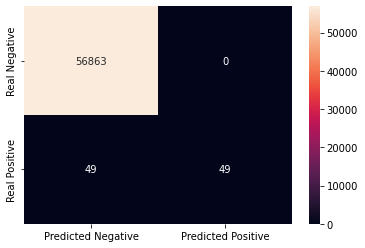

In [ ]:
#Random Forest Classifier Confusion Matrix
cm = confusion_matrix(original_ytest,y_pred) 
sns.heatmap(cm,annot=True,fmt='g',yticklabels=["Real Negative","Real Positive"],xticklabels=["Predicted Negative", "Predicted Positive"])

In [ ]:
print("Precision: ", round(precision*100,2),"%")
print("Recall: ", round(recall*100,2),"%")
print("F1: ", round(f1*100,2),"%")

Precision:  100.0 %
Recall:  50.0 %
F1:  66.67 %


In [ ]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))


Isolation Forest: 639
Accuracy Score :
0.9977563753699874
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.35      0.35      0.35       492

    accuracy                           1.00    284807
   macro avg       0.67      0.68      0.68    284807
weighted avg       1.00      1.00      1.00    284807



KeyboardInterrupt: ignored

## 3.2 Logistic Regression 

In [ ]:
X_oversample_test, y_oversample_test = borderlineSMOTE.fit_resample(original_Xtest, original_ytest)

In [ ]:
# # Measuring the time of applying Logistic Regression on dataset
# t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(X_oversample_train, y_oversample_train)
# t1 = time.time()
# print("Fitting oversample data took :{} sec".format(t1 - t0))

LogisticRegression(C=0.1)

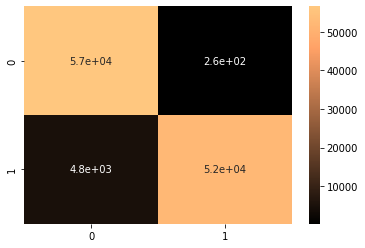

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_log_reg = log_reg_sm.predict(X_oversample_test)

log_reg_cf = confusion_matrix(y_oversample_test, y_pred_log_reg)

sns.heatmap(log_reg_cf, annot=True, cmap=plt.cm.copper)

In [ ]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_oversample_test, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56863
           1       1.00      0.92      0.95     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726



In [ ]:
# Testing on original dataset
# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X)
original_score = accuracy_score(y, y_pred)

In [ ]:
y_pred_sm = log_reg.predict(X_oversample_test)
oversample_score = accuracy_score(y_oversample_test, y_pred_sm)

In [ ]:
d = {'Technique': ['Original dataset', 'Oversampling (SMOTE)'], 'Score': [original_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Original dataset,0.990927
1,Oversampling (SMOTE),0.955507
